In [1]:
import laspy
import numpy as np
from sklearn import linear_model, decomposition
import open3d as o3d
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
def read_las_file(las_path):
    # Read the LAS file
    las_data = laspy.read(las_path)

    # Extract the points and classifications from the LAS file
    points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()

    # Create an Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    #return as point cloud
    return pcd


In [3]:
pcd = read_las_file("finalprojectdata.laz")

In [51]:
number_of_pts = len(pcd.points)
number_of_pts
#o3d.visualization.draw_geometries([pcd])

In [50]:
pcd_ref, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.2)
number_of_pts2 = len(pcd_ref.points)
print(f'Reduced the cloud size by: {round(100-number_of_pts2/(number_of_pts )*100)}%')

Reduced the cloud size by: 23%


In [53]:
o3d.visualization.draw_geometries([pcd_ref])

In [6]:
# voxelize the cloud 
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_ref, voxel_size=1.0)


In [54]:
o3d.visualization.draw_geometries([voxel_grid])

In [8]:
points = np.asarray(pcd_ref.points)
voxel_size = voxel_grid.voxel_size

# Use defaultdict to store points temporarily
temp_voxel_points = defaultdict(list)

# Find the points inside each voxel
for point in points:
    voxel_index = tuple((np.floor(point / voxel_size)).astype(int))
    temp_voxel_points[voxel_index].append(point)

# Create final dictionary with only voxels having at least 10 points
voxel_points = {voxel_index: pts for voxel_index, pts in temp_voxel_points.items() if len(pts) >= 10}




In [9]:
num_of_voxels = len(voxel_points)
print(f'number of voxels: {num_of_voxels}')

pca = decomposition.PCA(n_components=3)
#create array to store values for all voxels
all_features = np.ones((num_of_voxels, 10 + 1)) # plus 1 to store voxel index

#test
print(len(list(voxel_points.keys())))

number of voxels: 522645
522645


In [10]:
def std_plane(points, voxel_size):
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

    # The centroid
    centroid = np.sum(points, axis=0)/points.shape[0]

    # Centered data
    c_data = points - centroid
    A = np.c_[c_data[:,0], c_data[:,1], np.ones(c_data.shape[0])]

    # Plane coefficients
    C,_,_,_ = np.linalg.lstsq(A, c_data[:,2], rcond=None)
    #       Z = C[0]*X + C[1]*Y + C[2]
    # =>    C[0]*X + C[1]*Y -1*Z + C[2] = 0

    # Distances from the plane
    distances = np.abs(C[0]*c_data[:,0] + C[1]*c_data[:,1] -1*c_data[:,2] + C[2]) / np.sqrt(C[0]**2 + C[1]**2 + 1)

    # Normalize distances
    distances /= voxel_size

    # Return the standard deviation
    return np.std(distances)



In [11]:
feature_dict = {}
#calculate PCA values for all voxels
for index, (key, values) in enumerate(voxel_points.items()):
    # Stack the arrays into a single 2D array
    all_points = np.stack(values)
    # Extract the z-values
    z_values = all_points[:, 2]
    
    pca.fit(all_points)
    explained_variance = pca.explained_variance_
    l1, l2, l3 = pca.explained_variance_

    sum_ev = explained_variance[0] + explained_variance[1] + explained_variance[2]
    L = (l1 - l2) / l1
    P = (l2 - l3) / l1
    S = l3 / l1
    O = (l1 * l2 * l3) ** (1 / 3)
    A = (l1 - l3) / l1
    E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
    change_curvature = l3 / l1+l2+l3
    z_range = np.max(z_values) - np.min(z_values)
    z_range = z_range / voxel_size
    plane_std = std_plane(points=all_points, voxel_size=1)

    feature_list = [L,P,S,O,A,E,change_curvature, z_range, plane_std, sum_ev]
    feature_dict[key] = feature_list

/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_18455/1642950325.py:19: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_18455/1642950325.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_18455/1642950325.py:19: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_18455/1642950325.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))


In [12]:
feature_dict

{(569749, 7033800, 9): [0.7991459407570122,
  0.1990034793765355,
  0.0018505798664523205,
  0.006213496614034345,
  0.9981494201335477,
  0.2833607801641344,
  0.019368005080367057,
  0.08999999999999986,
  0.004281409630166471,
  0.10393589738542279],
 (569750, 7033800, 8): [0.18798014767385637,
  0.8078264400029933,
  0.004193412323150415,
  0.012367795467185555,
  0.9958065876768496,
  0.38883213781714837,
  0.07129269409149863,
  0.129999999999999,
  0.010162332182952689,
  0.1493073083644108],
 (569751, 7033800, 8): [0.16950003698397018,
  0.8286169639994468,
  0.0018829990165830546,
  0.009828206317807639,
  0.9981170009834169,
  0.39712787187181076,
  0.07236326645489681,
  0.08000000000000007,
  0.006418082687371117,
  0.15515315318096107],
 (569752, 7033800, 8): [0.3658202263345217,
  0.6327991504353153,
  0.0013806232301629784,
  0.010893841322256254,
  0.998619376769837,
  0.4385745330823101,
  0.07375341930941241,
  0.129999999999999,
  0.0063250583102866164,
  0.186245209

In [13]:
df = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['linearity','planarity','scattering', 'omnivariance', 'anistropy', 'eigenentropy', 'change_curvature', 'z_range', 'plane_std', 'sum_ev'])
df


,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569749, 7033800, 9)",0.79915,0.19900,0.00185,0.00621,0.99815,0.28336,0.01937,0.09000,0.00428,0.10394
"(569750, 7033800, 8)",0.18798,0.80783,0.00419,0.01237,0.99581,0.38883,0.07129,0.13000,0.01016,0.14931
"(569751, 7033800, 8)",0.16950,0.82862,0.00188,0.00983,0.99812,0.39713,0.07236,0.08000,0.00642,0.15515
"(569752, 7033800, 8)",0.36582,0.63280,0.00138,0.01089,0.99862,0.43857,0.07375,0.13000,0.00633,0.18625
"(569753, 7033800, 8)",0.34611,0.65268,0.00121,0.01061,0.99879,0.44412,0.07642,0.11000,0.00717,0.19002
...,...,...,...,...,...,...,...,...,...,...
"(570240, 7034353, 12)",0.57035,0.40187,0.02778,0.02306,0.97222,0.38399,0.07394,0.46000,0.03321,0.14708
"(570239, 7034352, 12)",0.47688,0.45797,0.06515,0.03742,0.93485,0.45549,0.13306,0.65000,0.04997,0.18333
"(570238, 7034351, 12)",0.50010,0.47551,0.02439,0.02047,0.97561,0.36689,0.07102,0.30000,0.03493,0.13554
"(570223, 7034319, 37)",0.78426,0.20431,0.01142,0.01503,0.98858,0.34229,0.03669,0.57000,0.01920,0.13652


array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

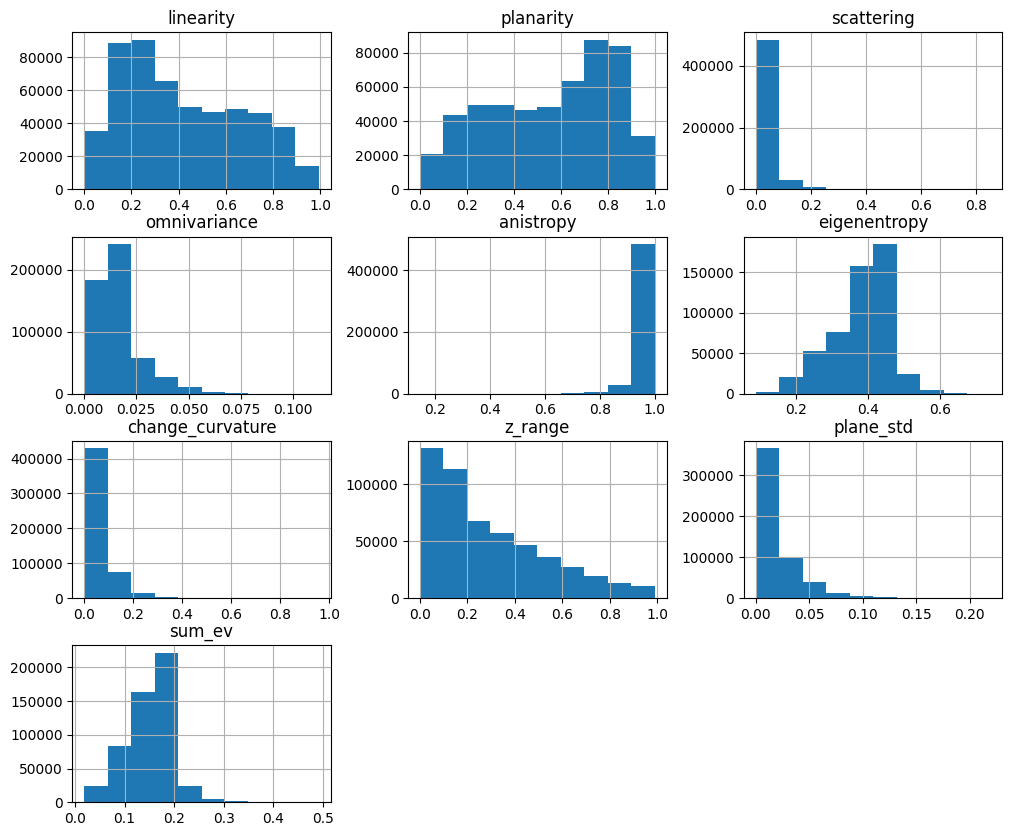

In [14]:
df.hist(figsize=(12,10))

In [15]:
tree_areas= [((570331, 7034100), (570373, 7034125)), ((569779, 7033836),(569851, 7033922))]
building_areas = [((569738,7034147),(569767, 7034185)),((569739,7034199),(569764, 7034231))]
terrain_areas = [((570382, 7034021),(570426, 7034045)), ((570314, 7033759),(570379, 7033787))]
    

In [16]:
def find_voxels_in_df(df, min_east, min_north, max_east, max_north):
    """
    Find all voxels within the specified 2D coordinates based on a DataFrame.
    """
    selected_voxels = []

    # Iterate through the DataFrame indices
    for index in df.index:
        # Check if the index (voxel coordinate) falls within the specified 2D coordinate range
        if min_east <= index[0] <= max_east and min_north <= index[1] <= max_north:
            selected_voxels.append(index)
    return selected_voxels
    

In [17]:
voxels_in_range_trees = find_voxels_in_df(df, 570331, 7034100, 570373, 7034125)
voxels_in_range_trees2 = find_voxels_in_df(df, 569779, 7033836,569851, 7033922)
len(voxels_in_range_trees2)

5667

In [18]:
voxels_in_range_buildings = find_voxels_in_df(df,569738,7034147,569767, 7034185)
voxels_in_range_buildings2 = find_voxels_in_df(df,569739,7034199,569764, 7034231)
len(voxels_in_range_buildings2)

1183

In [19]:
voxels_in_range_terrain = find_voxels_in_df(df,570382, 7034021,570426, 7034045)
voxels_in_range_terrain2 = find_voxels_in_df(df,570312, 7033878,570341, 7033907)

len(voxels_in_range_terrain2)

1001

In [20]:
def extract_points_from_dict(dict, voxel_indices):
    interest_cloud = o3d.geometry.PointCloud()
    for index in voxel_indices:
        points = dict[index]
        tmp_cloud = o3d.geometry.PointCloud()
        tmp_cloud.points = o3d.utility.Vector3dVector(np.stack(points))
        interest_cloud += tmp_cloud
    return interest_cloud

def extract_points_from_df(df, voxel_indices):
    # Filter the DataFrame
    filtered_df = df.loc[voxel_indices]
    return filtered_df

def filter_df_by_z_threshold(df, z_threshold):

    # Find the lowest z-value in the DataFrame index
    min_z = min(idx[2] for idx in df.index)

    # Filter out points within the z-value threshold of the lowest point
    filtered_df = df[[idx[2] > min_z + z_threshold for idx in df.index]]

    return filtered_df

In [55]:
tree_cloud = extract_points_from_dict(voxel_points, voxels_in_range_trees2 )
# Visualize
o3d.visualization.draw_geometries([tree_cloud]) 

In [82]:
#small cleaning to not include terrain pts
tree_df = extract_points_from_df(df, voxels_in_range_trees)
tree_df2 = extract_points_from_df(df, voxels_in_range_trees2)
tree_df_filtered = filter_df_by_z_threshold(tree_df, z_threshold=10)
tree_df_filtered2 = filter_df_by_z_threshold(tree_df2, z_threshold=7)
trees_dfs = [tree_df_filtered, tree_df_filtered2]
tree_combined_df = pd.concat(trees_dfs)



TypeError: concat() takes 1 positional argument but 2 were given

In [57]:
tree_cloud = extract_points_from_dict(voxel_points, tree_df_filtered2.index)
# Visualize
o3d.visualization.draw_geometries([tree_cloud]) 

In [25]:
building_df = extract_points_from_df(df, voxels_in_range_buildings + voxels_in_range_buildings2)
building_df_filtered=filter_df_by_z_threshold(building_df, z_threshold=5)
building_df_filtered

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569744, 7034152, 19)",0.85048,0.14543,0.00409,0.00658,0.99591,0.25254,0.01600,0.06000,0.01112,0.08948
"(569743, 7034152, 19)",0.75069,0.24564,0.00367,0.00586,0.99633,0.23445,0.01893,0.05000,0.00800,0.07562
"(569743, 7034152, 20)",0.55061,0.44568,0.00371,0.01157,0.99629,0.36719,0.04794,0.15000,0.00896,0.14187
"(569744, 7034152, 20)",0.40540,0.59138,0.00322,0.01004,0.99678,0.35136,0.05155,0.14000,0.00974,0.12916
"(569744, 7034151, 20)",0.34091,0.65631,0.00278,0.01366,0.99722,0.43927,0.07667,0.20000,0.01013,0.18553
...,...,...,...,...,...,...,...,...,...,...
"(569742, 7034199, 20)",0.25619,0.72021,0.02360,0.03060,0.97640,0.48153,0.11397,0.67000,0.03359,0.20812
"(569743, 7034204, 20)",0.62235,0.37556,0.00209,0.00858,0.99791,0.33972,0.03733,0.46000,0.00686,0.12804
"(569743, 7034203, 20)",0.57711,0.41867,0.00422,0.01073,0.99578,0.34048,0.04201,0.38000,0.01065,0.12629
"(569743, 7034202, 20)",0.75982,0.23835,0.00183,0.00680,0.99817,0.29962,0.02345,0.29000,0.00813,0.11095


In [60]:
building_cloud = extract_points_from_dict(voxel_points, building_df_filtered.index)
o3d.visualization.draw_geometries([building_cloud]) 

In [62]:
terrain_cloud = extract_points_from_dict(voxel_points, voxels_in_range_terrain)
# Visualize
o3d.visualization.draw_geometries([terrain_cloud])

In [28]:
terrain_df = extract_points_from_df(df, voxels_in_range_terrain +  voxels_in_range_terrain2)
terrain_df

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(570382, 7034045, 54)",0.41638,0.58228,0.00134,0.01032,0.99866,0.42514,0.06694,0.30000,0.00639,0.17775
"(570382, 7034044, 54)",0.13625,0.86238,0.00137,0.01022,0.99863,0.43443,0.08502,0.25000,0.00723,0.18035
"(570382, 7034043, 54)",0.16666,0.83122,0.00212,0.01111,0.99788,0.41805,0.07897,0.24000,0.00859,0.16884
"(570383, 7034045, 54)",0.36477,0.63462,0.00061,0.00820,0.99939,0.43503,0.07215,0.28000,0.00532,0.18405
"(570382, 7034042, 54)",0.17545,0.82277,0.00177,0.00969,0.99823,0.39825,0.07233,0.22000,0.00700,0.15594
...,...,...,...,...,...,...,...,...,...,...
"(570312, 7033907, 37)",0.59751,0.40108,0.00141,0.00937,0.99859,0.38881,0.04714,0.05000,0.00760,0.15897
"(570321, 7033902, 53)",0.95130,0.01818,0.03051,0.02735,0.96949,0.43028,0.04950,0.79000,0.05096,0.25865
"(570324, 7033905, 53)",0.75258,0.20145,0.04597,0.01698,0.95403,0.28908,0.06813,0.22000,0.03257,0.09766
"(570327, 7033906, 53)",0.81618,0.11447,0.06935,0.01599,0.93065,0.26402,0.08668,0.33000,0.04622,0.08578


array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

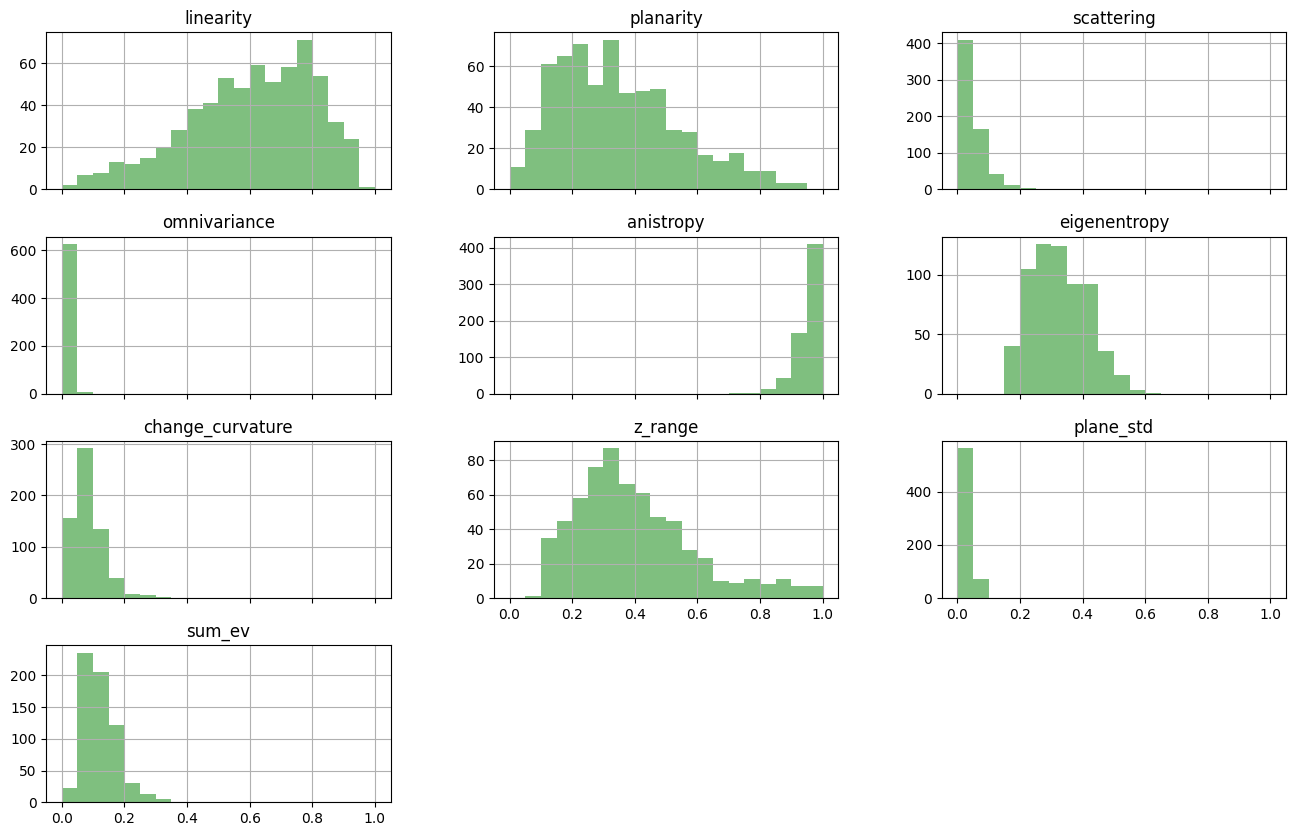

In [86]:
bin_range = [0, 1]
num_bins = 20 
tree_df_filtered.hist(color='green', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

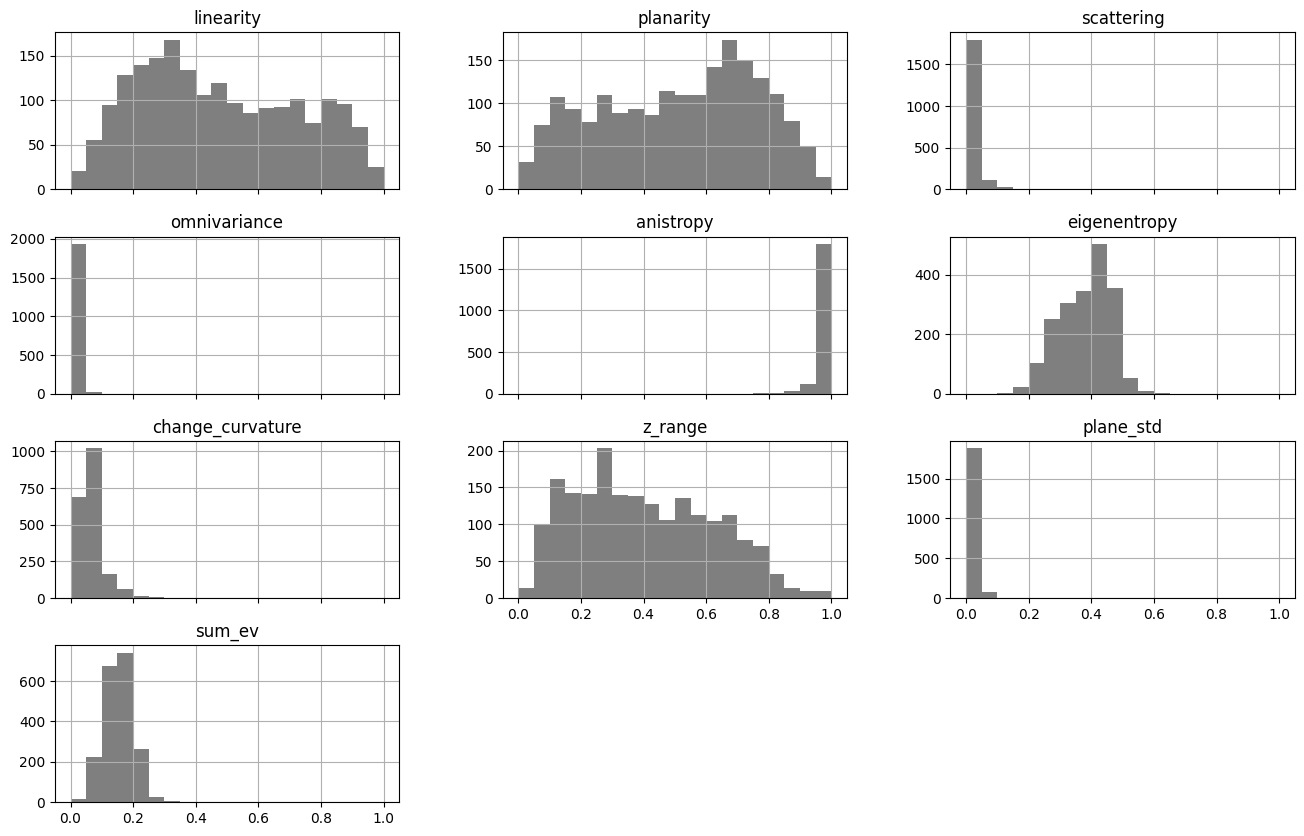

In [31]:
building_df_filtered.hist(color='black', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

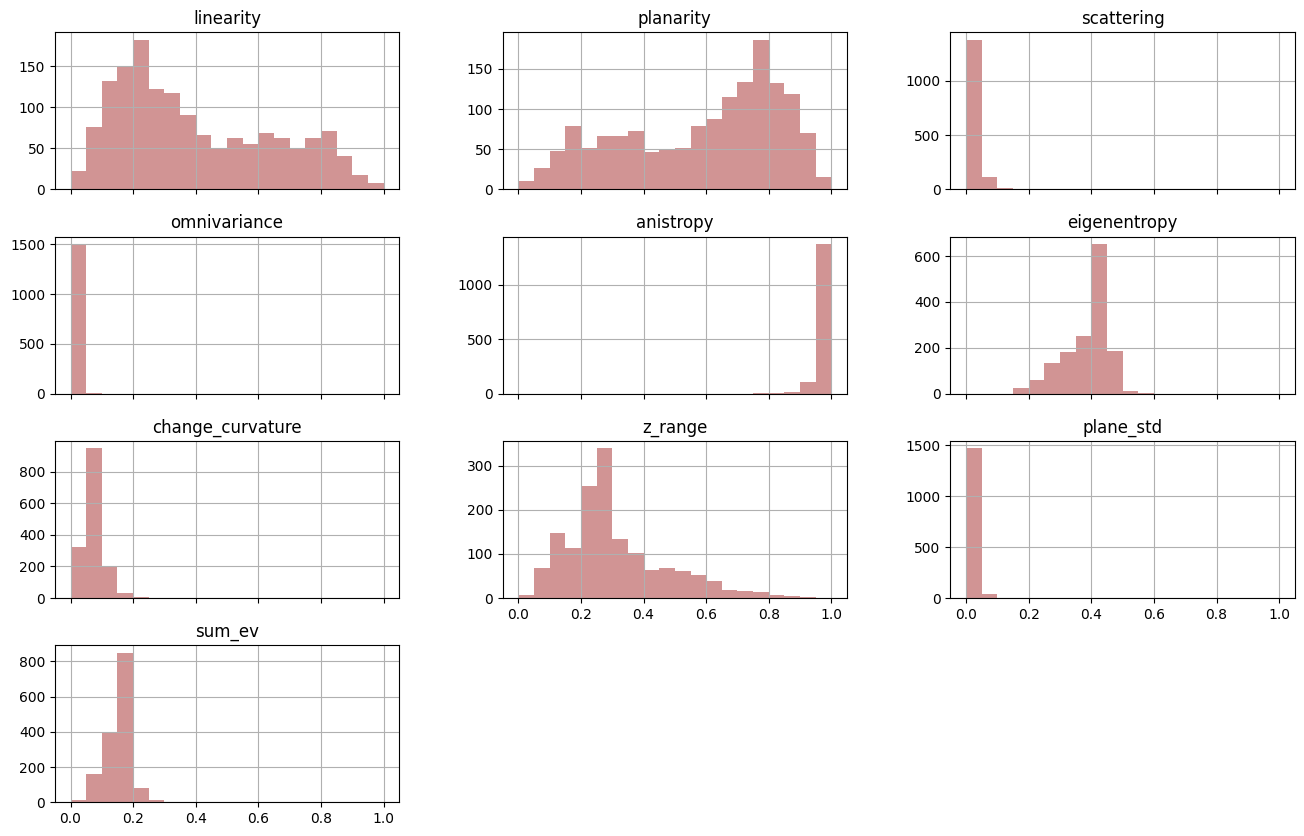

In [32]:
terrain_df.hist(color='brown', bins=num_bins, range=bin_range, figsize=(16,10), sharex=True, alpha=0.5)

In [88]:
# Calculate averages
average_trees = tree_df_filtered2.mean()
average_buildings = building_df_filtered.mean()
average_terrain = terrain_df.mean()

# Display the averages
print("Average for Trees:\n", average_trees)
print()
print("Average for Buildings:\n",average_buildings)
print()
print("Average for Terrain:\n", average_terrain)
print()

Average for Trees:
 linearity          0.60631
planarity          0.33568
scattering         0.05801
omnivariance       0.02216
anistropy          0.94199
eigenentropy       0.33501
change_curvature   0.09464
z_range            0.40463
plane_std          0.03586
sum_ev             0.12751
dtype: float64

Average for Buildings:
 linearity          0.47494
planarity          0.51108
scattering         0.01398
omnivariance       0.01514
anistropy          0.98602
eigenentropy       0.38016
change_curvature   0.06767
z_range            0.40168
plane_std          0.01689
sum_ev             0.15322
dtype: float64

Average for Terrain:
 linearity          0.39840
planarity          0.58533
scattering         0.01627
omnivariance       0.01540
anistropy          0.98373
eigenentropy       0.38600
change_curvature   0.07481
z_range            0.30840
plane_std          0.01741
sum_ev             0.15339
dtype: float64



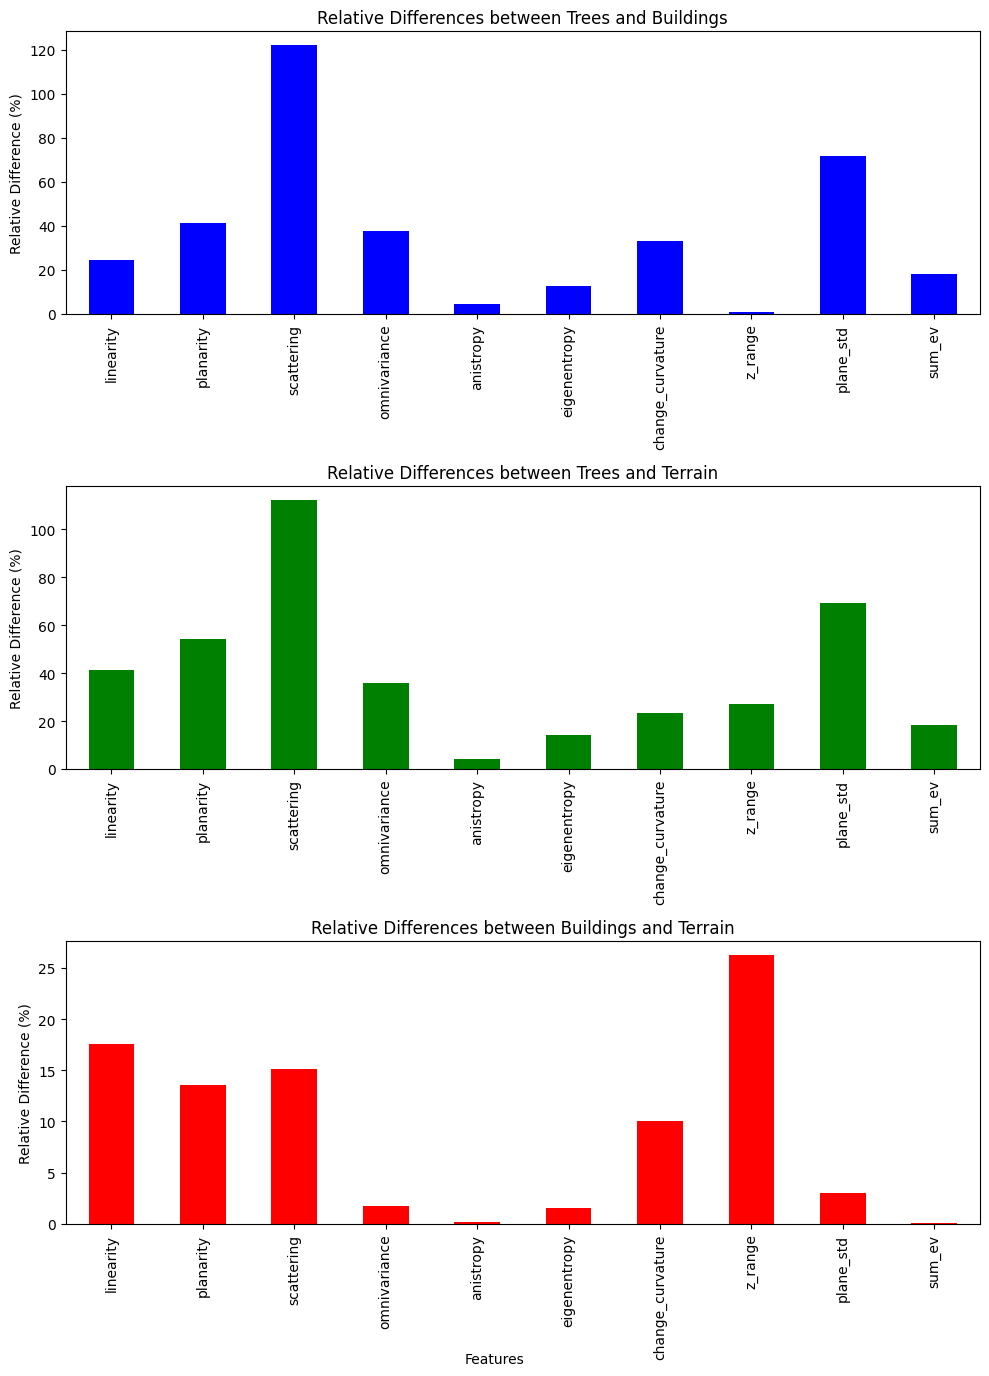

relative_diff_trees_buildings linearity           24.29952
planarity           41.42729
scattering         122.30156
omnivariance        37.68620
anistropy            4.56702
eigenentropy        12.62478
change_curvature    33.23186
z_range              0.73185
plane_std           71.90967
sum_ev              18.31822
dtype: float64
relative_diff_trees_terrain linearity           41.38737
planarity           54.21199
scattering         112.38311
omnivariance        35.99884
anistropy            4.33503
eigenentropy        14.14288
change_curvature    23.39818
z_range             26.99054
plane_std           69.27296
sum_ev              18.42820
dtype: float64
relative_diff_buildings_terrain linearity          17.52857
planarity          13.54522
scattering         15.11073
omnivariance        1.74660
anistropy           0.23211
eigenentropy        1.52491
change_curvature   10.02862
z_range            26.27167
plane_std           3.01179
sum_ev              0.11092
dtype: float64


In [89]:
# Calculate relative differences between each feature as a percentage
relative_diff_trees_buildings = abs((average_trees - average_buildings) / ((average_trees + average_buildings) / 2)) * 100
relative_diff_trees_terrain = abs((average_trees - average_terrain) / ((average_trees + average_terrain) / 2)) * 100
relative_diff_buildings_terrain = abs((average_buildings - average_terrain) / ((average_buildings + average_terrain) / 2)) * 100

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot each Series on its own subplot
relative_diff_trees_buildings.plot(kind='bar', ax=axes[0], color='blue', title='Relative Differences between Trees and Buildings')
relative_diff_trees_terrain.plot(kind='bar', ax=axes[1], color='green', title='Relative Differences between Trees and Terrain')
relative_diff_buildings_terrain.plot(kind='bar', ax=axes[2], color='red', title='Relative Differences between Buildings and Terrain')

# Set labels for x and y axis
axes[0].set_ylabel('Relative Difference (%)')
axes[1].set_ylabel('Relative Difference (%)')
axes[2].set_ylabel('Relative Difference (%)')

# Set a common x label
fig.text(0.5, 0.04, 'Features', ha='center', va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

print('relative_diff_trees_buildings', relative_diff_trees_buildings)
print('relative_diff_trees_terrain',relative_diff_trees_terrain)
print('relative_diff_buildings_terrain',relative_diff_buildings_terrain)

In [138]:
# Use  linearity, planarity, scattering and z-values to classify the point cloud
avgs_trees = (average_trees.iloc[0], average_trees.iloc[1], average_trees.iloc[2], average_trees.iloc[7], average_trees.iloc[8] )

avgs_buildings = (average_buildings.iloc[0], average_buildings.iloc[1], average_buildings.iloc[2], average_buildings.iloc[7], average_buildings.iloc[8])

avgs_terrain = (average_terrain.iloc[0], average_terrain.iloc[1], average_terrain.iloc[2], average_terrain.iloc[7], average_terrain.iloc[8])

avgs ={
    'Trees': avgs_trees,
    'Buildings': avgs_buildings,
    'Terrain': avgs_terrain
}
avgs

{'Trees': (0.6063064892923669,
  0.33568238905547815,
  0.058011121652155,
  0.40462565104166687,
  0.035861321798494),
 'Buildings': (0.47493790895106247,
  0.5110771339957908,
  0.013984957053146752,
  0.40167520491803305,
  0.016893435703549075),
 'Terrain': (0.39839641910651885,
  0.5853326829599903,
  0.01627089793349089,
  0.3084007962840084,
  0.017410008988864318)}

In [ ]:
def calculate_features(averages, features):
    """
    :param averages: dict over averages
    :param features: list of index of features to calculate threshold
    :return: dict over thresholds
    """
    thresholds={}
    for key, value in averages.iterrows():
        key
        
        
    
    

In [184]:
def classify_voxel(row, avgs, thresholds, features):
    """
    Classify a voxel using majority voting based on relative differences.

    :param row: A row from the DataFrame representing a voxel.
    :param avgs: Dictionary with category averages for each feature.
    :param thresholds: Thresholds for considering a difference significant.
    :param features: List of features in the order they appear in the tuples.
    :return: The classification.
    """
    votes = {'Trees': 0, 'Buildings': 0, 'Terrain': 0}
    # Iterate over features and calculate votes
    for i, feature in enumerate(features):
        category = min(avgs.keys(), key=lambda cat: abs(row[feature] - avgs[cat][i]))
        if abs(row[feature] - avgs[category][i]) < thresholds[feature]:
            votes[category] += 1

    # Determine the classification
    max_votes = max(votes.values())
    if max_votes >= 3:  # Majority voting
        return max(votes, key=votes.get)
    else:
        return 'Unknown'

features = ['linearity', 'planarity', 'scattering', 'z_range', 'plane_std']  # #features to examine
#thresholds = {feature: 20 for feature in features}  # threshold values
thresholds = {'linearity': 0.72, 'planarity': 0.68, 'scattering': 0.042, 'z_range':0.54 , 'plane_std': 0.033}

classified_df = df.copy()
classified_df['classification'] = classified_df.apply(lambda row: classify_voxel(row, avgs, thresholds, features), axis=1)


In [185]:
def count_classifications(df, classification_column):
    """
    Count the number of each classification in the DataFrame.
    """
    return df[classification_column].value_counts()

classification_counts = count_classifications(classified_df, 'classification')
print(classification_counts)


previous classification
Terrain      220799
Unknown      209699
Trees         65314
Buildings     26833
Name: count, dtype: int64
classification
Terrain      239329
Unknown      140697
Trees         98474
Buildings     44145
Name: count, dtype: int64


In [186]:
non_terrain_df = classified_df[classified_df['classification'] != 'Terrain']
non_terrain_df

,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev,classification
"(569749, 7033800, 9)",0.79915,0.19900,0.00185,0.00621,0.99815,0.28336,0.01937,0.09000,0.00428,0.10394,Unknown
"(569755, 7033800, 8)",0.55897,0.44015,0.00088,0.00793,0.99912,0.38751,0.04887,0.11000,0.00542,0.15658,Buildings
"(569745, 7033809, 10)",0.23545,0.76310,0.00145,0.01149,0.99855,0.45480,0.08650,0.36000,0.00686,0.19607,Buildings
"(569745, 7033806, 10)",0.30223,0.69559,0.00219,0.01350,0.99781,0.45835,0.08429,0.38000,0.00891,0.19940,Buildings
"(569744, 7033805, 10)",0.22341,0.77445,0.00215,0.01353,0.99785,0.46445,0.09100,0.40000,0.00991,0.20295,Buildings
...,...,...,...,...,...,...,...,...,...,...,...
"(570241, 7034354, 12)",0.11627,0.80089,0.08285,0.03246,0.91715,0.41455,0.15785,0.44000,0.04352,0.15259,Trees
"(570240, 7034353, 12)",0.57035,0.40187,0.02778,0.02306,0.97222,0.38399,0.07394,0.46000,0.03321,0.14708,Trees
"(570239, 7034352, 12)",0.47688,0.45797,0.06515,0.03742,0.93485,0.45549,0.13306,0.65000,0.04997,0.18333,Trees
"(570238, 7034351, 12)",0.50010,0.47551,0.02439,0.02047,0.97561,0.36689,0.07102,0.30000,0.03493,0.13554,Unknown


In [187]:
# we fine-tune a function to distinguish building from trees based on scattering and plane_std
def classify_building_tree(row, avgs):
    """
    Classify a voxel as either 'Building' or 'Tree' using majority voting based on 'scattering' and 'plane_std'.
    """
    votes = {'Trees': 0, 'Buildings': 0}

    # Iterate over the specified features
    for feature in ['scattering', 'plane_std']:
        # Determine which category is closer for the current feature
        closest_category = min(['Trees', 'Buildings'], key=lambda cat: abs(row[feature] - avgs[cat][feature]))
        votes[closest_category] += 1

    # Majority voting
    if votes['Trees'] > votes['Buildings']:
        return 'Trees'
    elif votes['Buildings'] > votes['Trees']:
        return 'Buildings'
    else:
        return 'Unknown'

avgs_trees_buildings = {
    'Trees': {'scattering': average_trees.iloc[2], 'plane_std': average_trees.iloc[8]},
    'Buildings': {'scattering': average_buildings.iloc[2], 'plane_std': average_buildings.iloc[8]}
}

# Apply the classification
non_terrain_df['classification'] = non_terrain_df.apply(lambda row: classify_building_tree(row, avgs_trees_buildings), axis=1)


/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_18455/2901012316.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_terrain_df['classification'] = non_terrain_df.apply(lambda row: classify_building_tree(row, avgs_trees_buildings), axis=1)


In [188]:
classification_counts_non_terrain = count_classifications(non_terrain_df, 'classification')
classification_counts_non_terrain

classification
Buildings    167193
Trees         89899
Unknown       26224
Name: count, dtype: int64

In [189]:

colors = {
    'Trees': [0, 1, 0],       # Green
    'Buildings': [0, 0, 1],   # Blue
    'Terrain': [1, 0.5, 0],  # Orange
    'Unknown': [0.5, 0.5, 0.5]  # Gray
}


# Use classification to paint each voxel in the point_cloud
complete_cloud = o3d.geometry.PointCloud()
for index, row in classified_df.iterrows():
    classification = row['classification']
    if classification == 'Terrain':
        tmp_cloud = o3d.geometry.PointCloud()
        points = np.stack(voxel_points[index])
        tmp_cloud.points = o3d.utility.Vector3dVector(points)
        tmp_cloud.paint_uniform_color(colors[classification])
        complete_cloud += tmp_cloud

for index, row in non_terrain_df.iterrows():
        classification = row['classification']
        tmp_cloud = o3d.geometry.PointCloud()
        points = np.stack(voxel_points[index])
        tmp_cloud.points = o3d.utility.Vector3dVector(points)
        tmp_cloud.paint_uniform_color(colors[classification])
        complete_cloud += tmp_cloud


o3d.visualization.draw_geometries([complete_cloud])

In [203]:
o3d.visualization.draw_geometries([complete_cloud])

In [198]:
#visualize as Voxel grid
new_voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(complete_cloud, voxel_size=1)
o3d.visualization.draw_geometries([new_voxel_grid])

In [208]:

def visualize_points_in_bounding_box(pcd, center_coordinate, box_size, grid):
    """
    Visualizes the voxels within a bounding box in a voxel grid.

    :param pcd: An Open3D PointCloud object.
    :param center_coordinate: The center coordinate of the bounding box.
    :param box_size: The size of the bounding box i 3D coordinates
    """
    # Calculate the min and max bounds of the bounding box
    min_bound = np.array(center_coordinate) - box_size / 2
    max_bound = np.array(center_coordinate) + box_size / 2

    # Create an AxisAlignedBoundingBox
    bounding_box = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)

    # Crop the point cloud using the bounding box
    cropped_pcd = pcd.crop(bounding_box)

    if grid:
        # Visualize the cropped point cloud as voxel grid
        new_voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(cropped_pcd, voxel_size=1)
        o3d.visualization.draw_geometries([new_voxel_grid])
        
    else:
    
        # Visualize as point cloud
        o3d.visualization.draw_geometries([new_voxel_grid])
    

midtbyen = [569772, 7034253, 7.5] 
center_coordinate = midtbyen  
box_size = 50
voxel_size = 1  

visualize_points_in_bounding_box(complete_cloud, center_coordinate, box_size, grid=True)


### NB: code below is not used for project

In [16]:
# Access a random row
random_row = df.sample()
print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]

inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)

o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel_elevated = o3d.geometry.PointCloud()

o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel_elevated.points = o3d.utility.Vector3dVector(inlier_points_array[:,:3]+[0,0,100])

o3dvoxel_elevated.paint_uniform_color([1,0,0])
o3dvoxel.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([o3dvoxel, o3dvoxel_elevated, pcd_ref])

random selected row:                        linearity  planarity  scattering  omnivariance  \
(570172, 7033825, 15)    0.11447    0.88244     0.00309       0.01119   

                       anistropy  eigenentropy  change_curvature  z_range  \
(570172, 7033825, 15)    0.99691       0.39153           0.07415  0.13000   

                       plane_std  sum_ev  
(570172, 7033825, 15)    0.00938 0.15101  


In [42]:
# Access a random row
random_row = df.sample()
#print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]

print(random_voxel_idx)
print(np.array((random_voxel_idx[0]- voxel_size/2, random_voxel_idx[1]- voxel_size/2, random_voxel_idx[2]- voxel_size/2) ))


# Assuming voxel_size is known, and random_voxel_idx is the center of the voxel
#voxel_center = np.array(voxel_points[random_voxel_idx][0])
# We calculate the 
voxel_center = np.array((random_voxel_idx[0]- voxel_size/2, random_voxel_idx[1]- voxel_size/2, random_voxel_idx[2]- voxel_size/2) )
half_size = 20  # Half the size of the bounding box

# Create a bounding box
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=voxel_center - half_size,
                                           max_bound=voxel_center + half_size)

# Extract points within the bounding box from the original point cloud
points_o3d = o3d.utility.Vector3dVector(np.asarray(pcd_ref.points))  # Convert to Vector3dVector
inlier_indices = bbox.get_point_indices_within_bounding_box(points_o3d)
inlier_points_array_bb = np.asarray(pcd_ref.points)[inlier_indices]

# Create a PointCloud for visualization
subchunk = o3d.geometry.PointCloud()
subchunk.points = o3d.utility.Vector3dVector(inlier_points_array_bb)
subchunk.paint_uniform_color([0,0,0])

# visualize the voxel
inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)
o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel.paint_uniform_color([0,1,0])


# Visualize
o3d.visualization.draw_geometries([subchunk, o3dvoxel])  


(569736, 7033994, 29)
[5.6973550e+05 7.0339935e+06 2.8500000e+01]


In [19]:
tree_indices = [(570368, 7034210, 54),(570083, 7034144, 27), (569803, 7033919, 33), (569739, 7034333, 17), (570349, 7034136, 53), (570236, 7034122, 36), (570074, 7033931, 34) ]
building_indices = [ (569776, 7034285, 22), (569911, 7034328, 16), (570227, 7034315, 22), (570031, 7034021, 12), (569820, 7034360, 24), (569600, 7034260, 26) ]
terrain_indices = [ (570261, 7033803, 23), (569638, 7034074, 12), (570134, 7034127, 27), (569772, 7034144, 10), (569663, 7034285, 9), (570171, 7034219, 21), (570241, 7033933, 29), (570127, 7033856, 16), (570095, 7033847, 9)]

In [20]:
# Function to calculate the average for each column based on indices
def calculate_average(df, indices):
    filtered_df = df.loc[indices]
    return filtered_df.mean()

# Calculate averages
average_trees = calculate_average(df, tree_indices)
average_buildings = calculate_average(df, building_indices)
average_terrain = calculate_average(df, terrain_indices)

# Display the averages
print("Average for Trees:\n", average_trees)
print()
print("Average for Buildings:\n", average_buildings)
print()
print("Average for Terrain:\n", average_terrain)
print()

Average for Trees:
 linearity          0.60925
planarity          0.31725
scattering         0.07350
omnivariance       0.02462
anistropy          0.92650
eigenentropy       0.34206
change_curvature   0.11244
z_range            0.43286
plane_std          0.04282
sum_ev             0.12579
dtype: float64

Average for Buildings:
 linearity          0.55365
planarity          0.44213
scattering         0.00421
omnivariance       0.01171
anistropy          0.99579
eigenentropy       0.36581
change_curvature   0.04928
z_range            0.42667
plane_std          0.01210
sum_ev             0.14548
dtype: float64

Average for Terrain:
 linearity          0.45208
planarity          0.53791
scattering         0.01001
omnivariance       0.01670
anistropy          0.98999
eigenentropy       0.41293
change_curvature   0.07142
z_range            0.28444
plane_std          0.01522
sum_ev             0.17456
dtype: float64



In [22]:
average_buildings

linearity          0.55365
planarity          0.44213
scattering         0.00421
omnivariance       0.01171
anistropy          0.99579
eigenentropy       0.36581
change_curvature   0.04928
z_range            0.42667
plane_std          0.01210
sum_ev             0.14548
dtype: float64

In [23]:

# Define a threshold for closeness
threshold = 0.20  # This is an example threshold, adjust it as needed

# Function to check if values are within the threshold of the average
def is_close_to_average(row, average, threshold):
    return all(abs(row[col] - average[col]) <= threshold * average[col] for col in average.index)

# List to store indices of rows close to the average
close_indices = []

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    if is_close_to_average(row, average_buildings, threshold):
        close_indices.append(idx)

# close_indices now contains the indices of rows close to the average for trees


In [24]:
len(close_indices)

1015

In [25]:
# find interest points from voxels with similar features:
interest_points = o3d.geometry.PointCloud()
for index in close_indices:
   
    points = voxel_points[index]
    tmp_cloud = o3d.geometry.PointCloud()
    tmp_cloud.points = o3d.utility.Vector3dVector(np.stack(points))
    interest_points += tmp_cloud



# Visualize pont clouds
interest_points.paint_uniform_color([1,0,0])
pcd_ref.paint_uniform_color([0,0,0])
o3d.visualization.draw_geometries([pcd_ref, interest_points]) 

    